Run the following line if you don't have any of the libraries

In [1]:
# %%bash
# pip install statsmodels pandas numpy

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

import data_prep

In [3]:
data_prep.get_lagged("./data/XLE_energy_etf.csv", n=3)

,Open,High,Low,Close,Adj Close,Volume,Adj Close_1,Adj Close_2,Adj Close_3
Date,,,,,,,,,
2010-01-07,59.740002,60.009998,59.299999,59.910000,45.627445,17449500,45.695988,45.155247,44.789688
2010-01-08,59.700001,60.349998,59.490002,60.299999,45.924469,13344300,45.627445,45.695988,45.155247
2010-01-11,60.689999,60.869999,59.730000,60.220001,45.863533,19459900,45.924469,45.627445,45.695988
2010-01-12,59.299999,59.709999,59.040001,59.349998,45.200943,21510600,45.863533,45.924469,45.627445
2010-01-13,59.320000,59.799999,58.520000,59.570000,45.368496,22137500,45.200943,45.863533,45.924469
...,...,...,...,...,...,...,...,...,...
2020-03-16,27.950001,31.120001,27.670000,27.809999,27.809999,40233600,32.189999,29.469999,33.669998
2020-03-17,28.080000,29.180000,26.950001,28.000000,28.000000,45443600,27.809999,32.189999,29.469999
2020-03-18,26.040001,26.580000,22.879999,23.980000,23.980000,52135800,28.000000,27.809999,32.189999


In [4]:
pd.read_csv("./data/SnP_500.csv", index_col="Date").head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


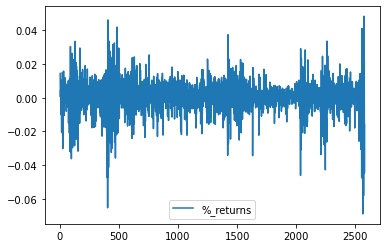

In [5]:
df_perc_returns = data_prep.get_perc_return("./data/SnP_500.csv", column_name="Open")
df_perc_returns.plot()

The way returns are distributed shows a stationary process with no correlation with time 
This also leads us to try out GARCH models since we proabably can model these spikes in volatility.

Following which, we'll look at the full dataset, a concatnation of all the variables together with S&P500

In [6]:
df, psuedo_OOB, OOB = data_prep.split_data("./data/output.csv")

Columns are laballed as such:  VARIABLE_SECTOR

In [7]:
SNP_daily_ret = (df['Adj Close_SNP500']/df['Adj Close_SNP500'].shift(1)) - 1
SNP_daily_ret = SNP_daily_ret.dropna()

In [8]:
mod = AutoReg(SNP_daily_ret, 1)
res = mod.fit()
res.summary()

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       Adj Close_SNP500   No. Observations:                 2387
Model:                     AutoReg(1)   Log Likelihood                7758.794
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Fri, 10 Apr 2020   AIC                             -9.339
Time:                        00:43:08   BIC                             -9.332
Sample:                             1   HQIC                            -9.336
                                 2387                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0005      0.000      2.411      0.016    8.66e-05       0.001
Adj Close_SNP500.L1    -0.0455      0.020     -2.227      0.026      -0.086      -0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -21.9599           +0.0000j           21.9599            0.5000
-----------------------------------------------------------------------------
"""

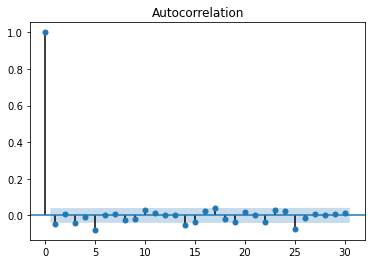

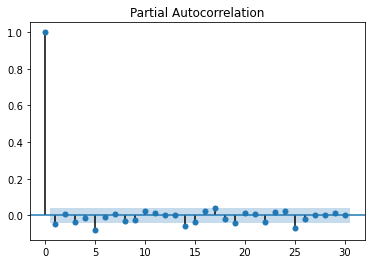

In [9]:
plot_acf(SNP_daily_ret, lags=30)
plt.show()
plot_pacf(SNP_daily_ret, lags=30)
plt.show()

The ACF shows that after lags of t=2, autocorrelation stays near 0 which means a **MA(2)** model

The PACF shows that after lags of t=2, autocorrelation stays near 0 which means an **AR(2)** model

In [10]:
mod = AutoReg(SNP_daily_ret, 2)
res = mod.fit()
res.summary()

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:       Adj Close_SNP500   No. Observations:                 2387
Model:                     AutoReg(2)   Log Likelihood                7755.117
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Fri, 10 Apr 2020   AIC                             -9.338
Time:                        00:43:08   BIC                             -9.328
Sample:                             2   HQIC                            -9.334
                                 2387                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept               0.0005      0.000      2.388      0.017    8.23e-05       0.001
Adj Close_SNP500.L1    -0.0452      0.020     -2.206      0.027      -0.085      -0.005
Adj Close_SNP500.L2     0.0079      0.020      0.387      0.699      -0.032       0.048
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -8.7414           +0.0000j            8.7414            0.5000
AR.2           14.4468           +0.0000j           14.4468            0.0000
-----------------------------------------------------------------------------
"""

In [11]:
ar2 = ARMA(SNP_daily_ret, order=[2,0])
ar2_fit = ar2.fit(disp=0)
print (ar2_fit.summary())
print('\n')

ma2 = ARMA(SNP_daily_ret, order=[0,2])
ma2_fit = ma2.fit(disp=0)
print (ma2_fit.summary())
print('\n')

arma11 = ARMA(SNP_daily_ret, order=[1,1])
arma11_fit = arma11.fit(disp=0)
print (arma11_fit.summary())
print('\n')


C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       Adj Close_SNP500   No. Observations:                 2387
Model:                     ARMA(2, 0)   Log Likelihood                7762.579
Method:                       css-mle   S.D. of innovations              0.009
Date:                Fri, 10 Apr 2020   AIC                         -15517.157
Time:                        00:43:09   BIC                         -15494.046
Sample:                             0   HQIC                        -15508.747
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004      0.000      2.402      0.016    8.16e-05       0.001
ar.L1.Adj Close_SNP500    -0.0452      0.020     -2.207      0.027      -0.085      -0.005
ar.L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       Adj Close_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 1)   Log Likelihood                7764.148
Method:                       css-mle   S.D. of innovations              0.009
Date:                Fri, 10 Apr 2020   AIC                         -15520.297
Time:                        00:43:10   BIC                         -15497.186
Sample:                             0   HQIC                        -15511.887
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004      0.000      2.366      0.018    7.61e-05       0.001
ar.L1.Adj Close_SNP500    -0.7796      0.128     -6.104      0.000      -1.030      -0.529
ma.L

AIC values for all the models are extremely similar and hence we look to BIC to decide the best model()

It seems like AR(2) does the best out of all the models.

However, as shown later, adding MA(q) to AR(2) to eliminate autocorrelations yields higher AIC than ARMA(1,1).

In [12]:
## some usful attributes that might be used in future
"""
arma22_fit.aic
arma22_fit.bic
arma22_fit.fittedvalues  ## return fitted values of the model
arma22_fit.predict(start=2568, end=2570)
"""

'\narma22_fit.aic\narma22_fit.bic\narma22_fit.fittedvalues  ## return fitted values of the model\narma22_fit.predict(start=2568, end=2570)\n'

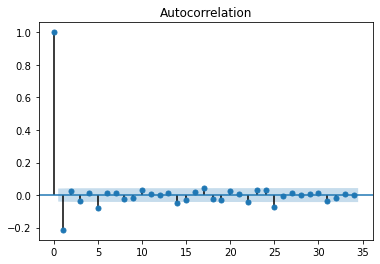

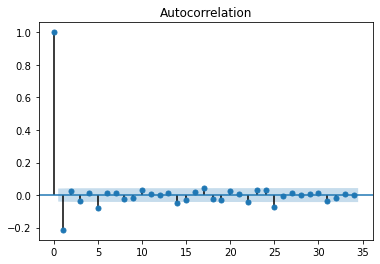

In [13]:
plot_acf(ar2_fit.fittedvalues)

2 lags are present in AR(2) model so we try to fit ARMA(2,2) to rid of the autocorrelations.

In [14]:
arma22 = ARMA(SNP_daily_ret, order=[2,2])
arma22_fit = arma22.fit(disp=0)
print (arma22_fit.summary())
print('\n')

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:       Adj Close_SNP500   No. Observations:                 2387
Model:                     ARMA(2, 2)   Log Likelihood                7770.862
Method:                       css-mle   S.D. of innovations              0.009
Date:                Fri, 10 Apr 2020   AIC                         -15529.724
Time:                        00:43:12   BIC                         -15495.057
Sample:                             0   HQIC                        -15517.108
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004   7.64e-05      5.864      0.000       0.000       0.001
ar.L1.Adj Close_SNP500     0.1676      0.121      1.384      0.167      -0.070       0.405
ar.L

AIC at -15529.724 is marginally lower than AR(2).

So far, our benchmarked models are:
- AR(2)
- ARMA(1,1)
- ARMA(2,2)

Moving on, we add more variables, to build ADL models that would hopefully beat our benchmark models

We'll start from one industry, build ARMA for models with lags $\in (1,5)$ and then look at their BIC values 

**Note:** we chose lags from 1 to 5 because 5 represents 1 trading week and we want to quickly be able to spot changes

We then choose the lagged_model with lowest BIC (BIC tend to give parsimonous model hence it would better fit our needs to prevent too many variables in our models to prevent overfitting) and iteratively add more industries up to the full model

Afterwords, we rid insignificant variables based on their t-stat. We do this iteratively with the final model till all the variables are significant. 

We note that this method may not be the best method since we didn't cover the full subset to see the lowest AIC/BIC but that is too computationally expensive.

By sampling 50 subsets of **n** variables, it will cover a signiicant subset and such iterative addition of variables is generally accepted in statistics.

In [15]:
## Adding more variables
from statsmodels.tsa.api import VAR
from statsmodels.regression.linear_model import OLS


def build_and_model_VAR(main_df:pd.DataFrame, var2add:list ):
    """
    Arguments:
    main_df - output.csv which has ALL the variables
    var2add - the industry, eg. Pharm. The value MUST be inside the colname 
    """
    temp_df = pd.DataFrame()
    for var in var2add:
        for col in main_df.columns:
            if "Open_"+var in col or "Volume_" + var in col:
                try:
                    temp_df.columns
                except:
                    temp_df = main_df[col]
                else:
                    temp_df = pd.concat([temp_df, main_df[col]], axis=1)
                    
    temp_df['Open_SNP500'] = main_df['Open_SNP500']
    temp_df['Volume_SNP500'] = main_df['Volume_SNP500']
    
    temp_df.index = main_df.index
        
    return temp_df

# lagged_df_exog(industries=["Pharm","Utilities"], col2lag=list(pharm_utils.columns))
def lagged_df_exog(industries:list, target="Open_SNP500", method="ARMA", order=[2,0], remove_vars=[]):
    temp_df = build_and_model_VAR(df, industries)
    y = temp_df[target][order[0]:]
    temp_df = temp_df.drop(target, axis=1)
    og = temp_df.columns 
    temp_df = data_prep.get_lagged_df(temp_df,col2lag=list(temp_df.columns), n=order[0])  ## lags every single var
    
    X_lagged = temp_df.drop(og, axis=1)
    if len(remove_vars) != 0:
        for colname in remove_vars:
            X_lagged = X_lagged.drop(colname, axis=1)
    
    if method == "ARMA":
        model = ARMA(y, order=order, exog=X_lagged)
    elif method == "OLS":
        model = OLS(y, X_lagged)
    else:
        raise Exception("method has to be 'ARMA' or 'OLS'.")
        
    results = model.fit()
    return results

full_industries = ["Pharm", "Semicon", "Industrial", "Energy", "Financial", "Tech", "Utilities", "Consumer"]
def best_lagged_model(industries:list, max_p_lag:int, max_q_lag=0, method="ARMA", start_ic=0, ic_method="BIC", print_summ=False):
    info = []
    ic = start_ic
    for p in range(1, max_p_lag+1):
        for q in range(max_q_lag+1):
            # q can be 0 but p has to be min 1
            try:
                temp_res = lagged_df_exog(industries=industries, order=[p,q])
                if print_summ:
                    print(temp_res.summary())
            except Exception:
                print(Exception)
                continue
            t = {
                    "order": [p,q],
                    "params": dict(temp_res.params),
                    "aic": temp_res.aic,
                    "bic": temp_res.bic,
                }
            info.append(t)
            if ic_method == "BIC":
                temp_ic = temp_res.bic
            elif ic_method == "AIC":
                temp_ic = temp_res.aic
            else:
                raise Exception("ic_method argument has to be 'BIC' or 'AIC'.")
            if ic == 0:  ## first iteration only
                ic = temp_ic
                res = temp_res
            elif temp_ic < ic:
                ic = temp_ic
                res = temp_res
    ## res will have the lowest ic. 
    ## info will be a list of dictionary
    return res, info

We look at the full model first and find the best lag for the full model.

In [16]:
df.columns
full_industries

['Pharm',
 'Semicon',
 'Industrial',
 'Energy',
 'Financial',
 'Tech',
 'Utilities',
 'Consumer']

In [17]:
res_full, info = best_lagged_model(full_industries, max_p_lag=5, max_q_lag=3, print_summ=True)

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 0)   Log Likelihood               -9992.204
Method:                       css-mle   S.D. of innovations             15.913
Date:                Fri, 10 Apr 2020   AIC                          20024.408
Time:                        00:43:13   BIC                          20139.964
Sample:                             0   HQIC                         20066.459
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.4183      3.475      4.436      0.000       8.607      22.230
Open_Pharm_L1            2.8500      0.025    114.527      0.000       2.801       2.899
Volume_Pharm

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 1)   Log Likelihood               -9953.034
Method:                       css-mle   S.D. of innovations             15.654
Date:                Fri, 10 Apr 2020   AIC                          19948.068
Time:                        00:43:16   BIC                          20069.402
Sample:                             0   HQIC                         19992.222
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.4183      3.474      4.439      0.000       8.610      22.226
Open_Pharm_L1            2.8500      0.023    124.813      0.000       2.805       2.895
Volume_Pharm

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 2)   Log Likelihood               -9907.312
Method:                       css-mle   S.D. of innovations             15.357
Date:                Fri, 10 Apr 2020   AIC                          19858.624
Time:                        00:43:22   BIC                          19985.736
Sample:                             0   HQIC                         19904.880
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.4183      4.120      3.742      0.000       7.343      23.493
Open_Pharm_L1            2.8500        nan        nan        nan         nan         nan
Volume_Pharm

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2387
Model:                     ARMA(1, 3)   Log Likelihood               -9898.676
Method:                       css-mle   S.D. of innovations             15.301
Date:                Fri, 10 Apr 2020   AIC                          19843.352
Time:                        00:43:24   BIC                          19976.242
Sample:                             0   HQIC                         19891.711
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.4183      4.566      3.377      0.001       6.468      24.368
Open_Pharm_L1            2.8500        nan        nan        nan         nan         nan
Volume_Pharm

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2386
Model:                     ARMA(2, 0)   Log Likelihood               -9890.371
Method:                       css-mle   S.D. of innovations             15.275
Date:                Fri, 10 Apr 2020   AIC                          19856.741
Time:                        00:43:27   BIC                          20076.282
Sample:                             0   HQIC                         19936.634
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.5375      4.413      3.067      0.002       4.888      22.187
Open_Pharm_L1            3.5941      0.780      4.610      0.000       2.066       5.122
Open_Pharm_L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2386
Model:                     ARMA(2, 1)   Log Likelihood               -9851.731
Method:                       css-mle   S.D. of innovations             15.030
Date:                Fri, 10 Apr 2020   AIC                          19781.461
Time:                        00:43:31   BIC                          20006.779
Sample:                             0   HQIC                         19863.456
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.5375      4.652      2.910      0.004       4.420      22.655
Open_Pharm_L1            3.5941      0.778      4.621      0.000       2.070       5.118
Open_Pharm_L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2386
Model:                     ARMA(2, 2)   Log Likelihood               -9834.171
Method:                       css-mle   S.D. of innovations             14.919
Date:                Fri, 10 Apr 2020   AIC                          19748.341
Time:                        00:43:38   BIC                          19979.436
Sample:                             0   HQIC                         19832.439
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.5375      5.622      2.408      0.016       2.519      24.556
Open_Pharm_L1            3.5941      0.762      4.718      0.000       2.101       5.087
Open_Pharm_L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2386
Model:                     ARMA(2, 3)   Log Likelihood               -9833.207
Method:                       css-mle   S.D. of innovations             14.913
Date:                Fri, 10 Apr 2020   AIC                          19748.414
Time:                        00:43:44   BIC                          19985.286
Sample:                             0   HQIC                         19834.614
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   13.5375      5.598      2.418      0.016       2.566      24.509
Open_Pharm_L1            3.5941      0.901      3.990      0.000       1.829       5.360
Open_Pharm_L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:            Open_SNP500   No. Observations:                 2385
Model:                     ARMA(3, 0)   Log Likelihood               -9817.001
Method:                       css-mle   S.D. of innovations             14.838
Date:                Fri, 10 Apr 2020   AIC                          19746.003
Time:                        00:43:53   BIC                          20069.512
Sample:                             0   HQIC                         19863.733
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.8897      5.300      2.810      0.005       4.502      25.277
Open_Pharm_L1            3.5897      0.753      4.765      0.000       2.113       5.066
Open_Pharm_L

C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\JJ\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)


KeyboardInterrupt: 

In [ ]:
import json
with open('./arma_adl_full.json', 'w') as fout:
    json.dump(info , fout)
    
"""
To load it:
with open('./arma_adl_full.json', 'w') as fin:
    info = json.load(fin)

print(info)
"""

In [ ]:
print(res_full.summary())

Seems like **ARMA(4,0)** fits the full model the best.

The full model has some variables where p-values are not significant. We remove some of those that have the highest p-values (> 0.5). And recompute the ARMA model after removing those variables.

### Extras

In [ ]:
pharm_utils = build_and_model_VAR(df, ["Pharm","Utilities"])
data_prep.get_lagged_df(pharm_utils,col2lag=list(pharm_utils.columns), n=3)

In [ ]:
print(res.aic)
print(res.bic)
print(res.fittedvalues[-10:])

"""
If the model is an ARMAX and out-of-sample forecasting is requested, exog must be given. 
exog must be aligned so that exog[0] is used to produce the first out-of-sample forecast.
"""
# print(res.predict(start=2568, end=2570))

res.summary()

In [ ]:
## forecasting
lag_order = results.k_ar
lag_order
# results.forecast(data.values[-lag_order:], 5)
# results.plot_forecast(10)

# We can do 2 tests as well, Granger casuality and Normality
results.test_causality('Open_SNP500', ['Open_Utilities', 'Open_Pharm'], kind='f')
# results.test_normality()

In [ ]:
df.columns